In [1]:
%matplotlib inline

import os
import pickle
import matplotlib.colors as colors
import palettable

import matplotlib.pyplot as plt

import matplotlib

import numpy as np

from configobj import ConfigObj

from matplotlib.colors import ListedColormap

import matplotlib.patches as patches

import h5py

### general style/labels used throughout the notebook

In [3]:
# Physics of Plasmas figure sizes
OneColWidth = 3.37
TwoColWidth = 6.69


IdLabels = {
    '512-2.0-1.000-1.000-0.50-3.00.CTU' : r'Sim 1.',
}

In [4]:
def createSimDict(firstId,lastId,AnaRess):
    return {
        "firstId": firstId,
        "lastId": lastId,
        "AnaRess" : AnaRess,
    }

### NOTE: the following three lines need to be changed/updated to reflect local data

In [5]:
Simulations = {
    '512-2.0-1.000-1.000-0.50-3.00.CTU' : createSimDict(0,100,[512]),    
}

In [6]:
#Ids = ['Athena512M2b5-longDt0.2',       
#      ]
Ids = list(Simulations.keys())

In [12]:
RootDir = '/u/pgrete/src/energy-transfer-analysis/testing/'

In [9]:
#RootDir = '/u/pgrete/results/'

# Read statistics 

In [8]:
FlowStats = {}

In [13]:


#Ids = Simulations.keys()

for Id in Ids:
    
    FlowStats[Id] = {}
        
    for AnaRes in Simulations[Id]["AnaRess"]:
        
        FlowStats[Id][AnaRes] = {}
        readFiles = 0         
        
        for Dump in np.arange(Simulations[Id]["firstId"],
                              Simulations[Id]["lastId"]+1):
        
            Dir = RootDir + Id

            
            File = Dir + "/" + str(Dump).zfill(4) +  "-stats-" + str(AnaRes) + ".hdf5"
            if not os.path.isfile(File):
                print("missing " + File)
                continue

            FlowStats[Id][AnaRes][Dump] = {}
            
            try:
                flowquant = h5py.File(File,"r")

                FlowStats[Id][AnaRes][Dump] = flowquant                

                readFiles += 1

            except:                    
                del FlowStats[Id][AnaRes][Dump]
                print("bad file " + File)

                
        print("Got %d flowQuants for %s at res %d" % (readFiles,Id,AnaRes))


Got 101 flowQuants for 512-2.0-1.000-1.000-0.50-3.00.CTU at res 512


# Temporal evolutions

In [14]:
def plotEvol(Ids):
    fig,p = plt.subplots(4,1,figsize=(OneColWidth,6),sharex=True)

    for Id in Ids:
        AnaRes = Simulations[Id]["AnaRess"][0]


        for i, Quan in enumerate([('u' + '/moments/' + 'rms','RMS $\mathrm{Ms}$',True),
                                  ('AlfvenicMach' + '/moments/' + 'rms',r'RMS $\mathrm{Ma}$',True),
                                  ('a' + '/moments/' + 'rms',r'RMS $\mathbf{a}$',False),
                                  ('rho-B/corr',r'$\mathrm{Corr}[\rho,B]$',True),
                                  #('Mean','KineticEnergy'),
                                  #('Mean','MagneticEnergy'),
                                  #('Mean','plasmabeta'),
                                 ]):

                
                QuanName = Quan[0]
                Label = Quan[1]
                Lin = Quan[2]
                
                addEvolToAxis(p[i],Id,AnaRes,QuanName)
                p[i].set_ylabel(Label)
                p[i].axvspan(3.,5.,color='gray',alpha=0.1)
                if not Lin:
                    p[i].set_yscale('log')
                p[i].grid()
                p[i].set_xlim(0.,5.)
        

    p[0].legend(ncol=3,loc="lower left",bbox_to_anchor=(-0.2,1.))
    p[-1].set_xlabel('time $t$ [$T$]')
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.01,hspace=0.00)


In [15]:
def addEvolToAxis(p,Id,AnaRes,QuanName):
    tmpY = []
    tmpX =[]
    for Dump in sorted(FlowStats[Id][AnaRes].keys()):
        if Dump == 0:
            continue
        tmpX.append(float(Dump)/20.)
        tmpY.append(FlowStats[Id][AnaRes][Dump][QuanName])

    p.plot(tmpX,tmpY,label=IdLabels[Id])
    

/u/pgrete/src/yt-conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


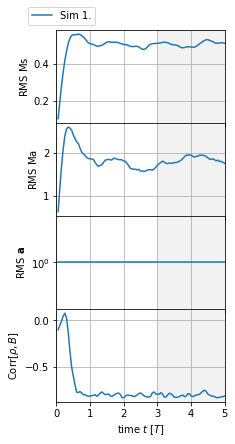

In [16]:
plotEvol(Ids)

# Spectra

### Via the Dump < X below, we control which spectra are included in the simulation. Given that this sim has 20 dumps per T, Dump < 40 means all Dump for 2T < t < 5 T

In [17]:
def getMeanSpec(Id,AnaRes,Quan,Type):
    tmp = []    
    for Dump in FlowStats[Id][AnaRes].keys():
        if Dump < 40:
            continue
        tmp.append(FlowStats[Id][AnaRes][Dump][Quan + '/PowSpec/'+Type][1])
    return FlowStats[Id][AnaRes][Dump][Quan + '/PowSpec/'+Type][0],  np.mean(tmp,axis=0), np.std(tmp,axis=0)
        

In [22]:
#['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
#              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
#              '#bcbd22', '#17becf']    

Colors = {
    '512-2.0-1.000-1.000-0.50-3.00.CTU':'#1f77b4',
    }

In [23]:
def getStyle(Id,Type):
    Style = {'color':Colors[Id]}
    
    if Type == 'Full':
        Style['label'] = IdLabels[Id]
    return Style

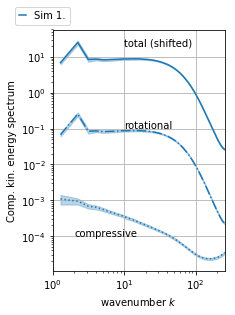

In [24]:
fig, p = plt.subplots(1,1,figsize=(OneColWidth,OneColWidth/1.6 * 2.),sharex=True)

p = [p]

Comp = {}
Comp["rhoU"] = 4./3.
Comp["B"] = 1.7
Comp['u'] = 4./3.
Low = 7.
Up = 20.
#Comp["KinEn"] = 0.
#Comp["MagEn"] = 0.
Type = 'Full'

Types = {
    'u' : ['Sol','Dil','Full'],
    'rhoU' : ['Sol','Dil','Full'],
    'B' : ['Full']
}


LabSuf = {
    'Sol' : r'$\perp$',
    'Dil' : r'$\parallel$',
    'Full' : ''
}

LS = {
    'Sol' : '-.',
    'Dil' : ':',
    'Full' : '-'
}

for i, Quan in  enumerate(['rhoU']):
        
    for Type in Types[Quan]:
        if Type == 'Full':
            Offset = 100.
        else:
            Offset = 1.
            
        for Id in Ids:
            AnaRes = Simulations[Id]["AnaRess"][0]        
            X,Y, Yerr = getMeanSpec(Id,AnaRes,Quan,Type)


            
            mask = np.logical_and(X < AnaRes/2,X != 0.)
            
            #Style = 
            p[i].plot(X[mask],Offset * X[mask]**Comp[Quan]*Y[mask],
                     ls=LS[Type],
                      **getStyle(Id,Type)
                     )
            
            
            p[i].fill_between(X[mask],
                              Offset * X[mask]**Comp[Quan] * (Y[mask] - Yerr[mask]),
                              Offset * X[mask]**Comp[Quan] * (Y[mask] + Yerr[mask]),
                             alpha=0.3,color=Colors[Id])
            
        #p[i].errorbar(X[mask],X[mask]**Comp[Type] * Y[mask],yerr=X[mask]**Comp[Type] *Yerr[mask],
        #              label=IdLabels[Id],
                      #elinewidth=0.2,
                     #ecolor=(0.,0.,0.,0.2)
        #             )
                     #error_kw={"alpha":0.2,"lw":0.2})
        
    
    #p[i].set_title(Type)
#for i in range(1):
#    p[i].axvspan(Low,Up, facecolor='black', alpha=0.05)

for i in range(1):
    p[i].set_xlim(1.,AnaRes/2)
    p[i].set_xscale("log")
    p[i].set_yscale("log")

#p[2].set_yscale("linear")    

#p[2].axhline(1.,color="black",alpha=0.2,lw=0.5)

p[0].set_ylabel("Comp. kin. energy spectrum")
#p[1].set_ylabel("Comp. kin. energy (split)")
#p[2].set_ylabel("Comp. mag. energy")
p[0].set_xlabel("wavenumber $k$")

#p[0].tick_params(axis='x', direction='in')
#p[0].tick_params(axis='x',tickdir='in')
#p[1].tick_params(axis='x', direction='in')
#p[1].tick_params(axis='x',tickdir='in')

p[0].legend(loc="lower left",ncol=5,
            handlelength=0.75,
            columnspacing=0.5,
            #fontsize=8,
            bbox_to_anchor=(-0.25,1.))

p[0].grid()
p[0].text(10,20,'total (shifted)')
p[0].text(10,1e-1,'rotational')
p[0].text(2,1e-4,'compressive')

fig.tight_layout()
fig.subplots_adjust(wspace=0.05,hspace=0.00)

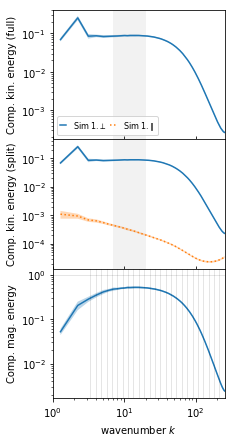

In [25]:
fig, p = plt.subplots(3,1,figsize=(OneColWidth,OneColWidth/1.6 * 3.),sharex=True)

Comp = {}
Comp["rhoU"] = 4./3.
Comp["B"] = 1.7
Comp['u'] = 4./3.
Low = 7.
Up = 20.
#Comp["KinEn"] = 0.
#Comp["MagEn"] = 0.
Type = 'Full'

Types = {
    'u' : ['Sol','Dil'],
    'rhoU' : ['Sol','Dil'],
    'B' : ['Full']
}


LabSuf = {
    'Sol' : r'$\perp$',
    'Dil' : r'$\parallel$',
    'Full' : ''
}

LS = {
    'Sol' : '-',
    'Dil' : ':',
    'Full' : '-'
}

for i, Quan in  enumerate(['rhoU',"rhoU","B"]):
        
    for Type in Types[Quan]:

        if i == 0:
            if Type == 'Dil':
                continue
            Type = 'Full'
            
        for Id in Ids:
            AnaRes = Simulations[Id]["AnaRess"][0]        
            X,Y, Yerr = getMeanSpec(Id,AnaRes,Quan,Type)


            mask = np.logical_and(X < AnaRes/2,X != 0.)
            p[i].plot(X[mask],X[mask]**Comp[Quan]*Y[mask],
                     label=IdLabels[Id] + LabSuf[Type],ls=LS[Type])
            
            p[i].fill_between(X[mask],
                              X[mask]**Comp[Quan] * (Y[mask] - Yerr[mask]),
                              X[mask]**Comp[Quan] * (Y[mask] + Yerr[mask]),
                             alpha=0.3)
        #p[i].errorbar(X[mask],X[mask]**Comp[Type] * Y[mask],yerr=X[mask]**Comp[Type] *Yerr[mask],
        #              label=IdLabels[Id],
                      #elinewidth=0.2,
                     #ecolor=(0.,0.,0.,0.2)
        #             )
                     #error_kw={"alpha":0.2,"lw":0.2})
        
    
    #p[i].set_title(Type)
for i in range(2):
    p[i].axvspan(Low,Up, facecolor='black', alpha=0.05)

RESexp = np.log(AnaRes/8)/np.log(2) * 4 + 1
BinsEdges = np.concatenate((np.array([0.]),
        4.* 2** ((np.arange(0,RESexp + 1) - 1.) /4.)))

for X in BinsEdges:
    p[2].axvline(X,color="black",alpha=0.2,lw=0.5)
                     
for i in range(3):
    p[i].set_xlim(1.,AnaRes/2)
    p[i].set_xscale("log")
    p[i].set_yscale("log")

#p[2].set_yscale("linear")    

p[2].axhline(1.,color="black",alpha=0.2,lw=0.5)

p[0].set_ylabel("Comp. kin. energy (full)")
p[1].set_ylabel("Comp. kin. energy (split)")
p[2].set_ylabel("Comp. mag. energy")
p[2].set_xlabel("wavenumber $k$")

p[0].tick_params(axis='x', direction='in')
p[0].tick_params(axis='x',tickdir='in')
p[1].tick_params(axis='x', direction='in')
p[1].tick_params(axis='x',tickdir='in')

p[1].legend(loc="lower left",ncol=4,
            handlelength=0.75,
            columnspacing=0.5,
            fontsize=8,bbox_to_anchor=(0.,1.))


fig.tight_layout()
fig.subplots_adjust(wspace=0.05,hspace=0.00)

# Histograms

#### again Dump < 40 here means that the mean histogram is only taken in the stationary phase

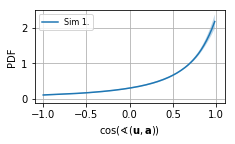

In [28]:
HistBins = 'globalMinMax'
def getMeanHist(Id,AnaRes,Quan):
    tmp = []    
    for Dump in FlowStats[Id][AnaRes].keys():
        if Dump < 40:
            continue
        X = FlowStats[Id][AnaRes][Dump][Quan + '/hist/' + HistBins + 'MinMax'][0]
        Vals = FlowStats[Id][AnaRes][Dump][Quan + '/hist/' + HistBins + 'MinMax'][1]
                
        TotSum = np.sum((X[1]-X[0])*Vals)
            
        tmp.append(Vals/TotSum)
    return (X,
            np.mean(tmp,axis=0), np.std(tmp,axis=0))
        
Quans = ['Angle_u_a']
NumRows = len(Quans)

fig, p = plt.subplots(NumRows,1,figsize=(OneColWidth,OneColWidth/1.6*NumRows))
if NumRows == 1:
    p = [p]
for i, Quan in enumerate(Quans):
    for Id in Ids:
        
        X,Y,YStd = getMeanHist(Id,AnaRes,Quan)
        
        
        p[i].plot(X[:-1],Y[:-1],label=IdLabels[Id])
        #p[1].plot(X,Y,label=IdLabels[Id])
        #print(YStd)
        p[i].fill_between(X,
                          Y - YStd,
                          Y + YStd,
                         alpha=0.3)        

    p[i].set_ylabel('PDF')

for i in range(NumRows):
    p[i].grid()
    p[i].set_xlabel('$\cos(\sphericalangle(\mathbf{u},\mathbf{a}))$')
#p[1].set_yscale('log')    
p[0].legend(loc='upper left',bbox_to_anchor=(0.,1.),ncol=3,fontsize=8)
fig.tight_layout()


#### Similarly, if we want to have an instantaneous histogram we just pick a Dump (here Dump 60)

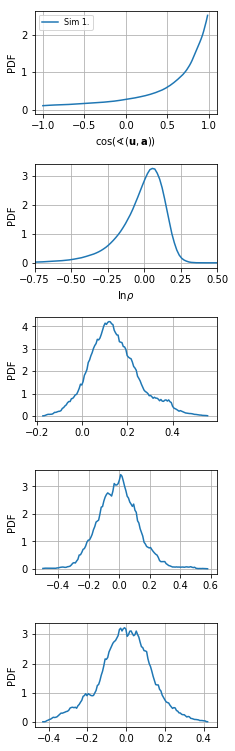

In [29]:
#HistBins = 'globalMinMax'
HistBins = 'Snap'
def getMeanHist(Id,AnaRes,Quan):
    tmp = []    
    for Dump in FlowStats[Id][AnaRes].keys():
        if Dump != 60:
            continue
        X = FlowStats[Id][AnaRes][Dump][Quan + '/hist/' + HistBins + 'MinMax'][0]
        Vals = FlowStats[Id][AnaRes][Dump][Quan + '/hist/' + HistBins + 'MinMax'][1]                
        TotSum = np.sum((X[1]-X[0])*Vals)
            
        tmp.append(Vals/TotSum)
    return (X,
            np.mean(tmp,axis=0), np.std(tmp,axis=0))
        
Quans = ['Angle_u_a',
         'lnrho',
         'LOSB_x',
         'LOSB_y',
         'LOSB_z',
        ]
NumRows = len(Quans)

fig, p = plt.subplots(NumRows,1,figsize=(OneColWidth,OneColWidth/1.6*NumRows))
if NumRows == 1:
    p = [p]
for i, Quan in enumerate(Quans):
    for Id in Ids:
        
        X,Y,YStd = getMeanHist(Id,AnaRes,Quan)
        
        
        p[i].plot(X[:-1],Y[:-1],label=IdLabels[Id])
        #p[1].plot(X,Y,label=IdLabels[Id])
        #print(YStd)
        p[i].fill_between(X,
                          Y - YStd,
                          Y + YStd,
                         alpha=0.3)        

    p[i].set_ylabel('PDF')

for i in range(NumRows):
    p[i].grid()

p[0].set_xlabel('$\cos(\sphericalangle(\mathbf{u},\mathbf{a}))$')
p[1].set_xlabel(r'$\ln \rho$')
#p[1].set_yscale('log')    
p[0].legend(loc='upper left',bbox_to_anchor=(0.,1.),ncol=3,fontsize=8)
p[1].set_xlim(-0.75,0.5)
fig.tight_layout()



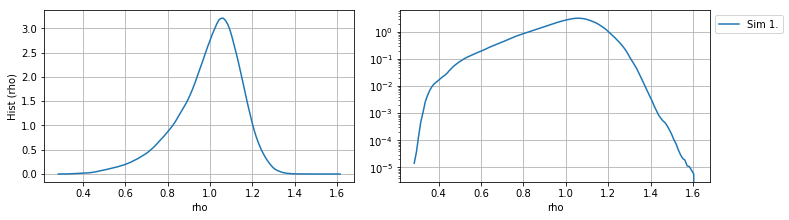

In [34]:
HistBins = 'Snap'
def getMeanHist(Id,AnaRes,Quan):
    tmp = []    
    for Dump in FlowStats[Id][AnaRes].keys():
        if Dump != 98:
            continue
        X = FlowStats[Id][AnaRes][Dump][Quan + '/hist/' + HistBins + 'MinMax'][0]
        Vals = FlowStats[Id][AnaRes][Dump][Quan + '/hist/' + HistBins + 'MinMax'][1]
        tmp.append(Vals/np.sum((X[1]-X[0])*Vals))
    return (X,
            np.mean(tmp,axis=0), np.std(tmp,axis=0))
        
Quans = ['rho']
NumRows = len(Quans)

fig, p = plt.subplots(NumRows,2,figsize=(3.*OneColWidth,1.5*OneColWidth/1.6))
#if NumRows == 1:
#    p = [p]
for i, Quan in enumerate(Quans):
    for Id in Ids:
        
        X,Y,YStd = getMeanHist(Id,AnaRes,Quan)
        p[0].plot(X,Y,label=IdLabels[Id])
        p[1].plot(X,Y,label=IdLabels[Id])
     

    p[i].set_ylabel('Hist (%s)' % Quan)

for i in range(2):
    p[i].grid()
    p[i].set_xlabel(Quan)
p[1].set_yscale('log')    
p[1].legend(loc='upper left',bbox_to_anchor=(1.,1.))
fig.tight_layout()



# 2d hist

#### Careful: numpy hist2d data is transposed with respect to plotting functions as pcolormesh

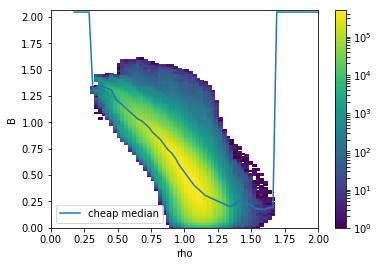

In [33]:
field = 'rho-B'
stat = 'globalMinMaxMinMax'
Dump = 80
bla = FlowStats[Ids[-1]][AnaRes][Dump][field + '/hist/' + stat]
X, Y = np.meshgrid(bla['edges'][0], bla['edges'][1])
Z = np.array(bla['counts']).T
plt.pcolormesh(X,Y,Z,
               norm=matplotlib.colors.LogNorm())

X = (bla['edges'][0][1:] + bla['edges'][0][:-1])/2.
Med = []
for i in range(len(Z[:,0])):
    # sum over columns
    totCells = np.sum(Z[:,i]) 
    for j in range(len(Z[:,i])):
        if np.sum(Z[:j,i]) > np.sum(Z[j:,i]):
            break
    Med.append(bla['edges'][1][j])                    
        
plt.plot(X,Med,label='cheap median')
plt.legend()
plt.xlabel('rho')
plt.ylabel('B')
plt.xlim(0.,2.0)
plt.colorbar()

# the total messy overview 

In [40]:
FieldNames = ['rho',
              'lnrho',
              'u',
              'a',
              'AbsDivU',
              'AbsRotU',
              'B',
              'AlfvenicMach',
              'plasmabeta',
              'DM_x',
              'DM_y',
              'DM_z',
              'RM_x',
              'RM_y',
              'RM_z',
              'lnDM_x',
              'lnDM_y',
              'lnDM_z',              
             ]

In [41]:
FieldNames += ['TotPres',
              'LOSB_x',
              'LOSB_y',
              'LOSB_z',
             ]

In [42]:
FieldNames += ['Angle_u_a',
              'Angle_uSol_a',
              'Angle_uDil_a',            
             ]

In [43]:
Stats = [
    'mean',    
    'stddev',
    'rms',
    'skew',
    'kurt',
#    'min',
#    'max'
]

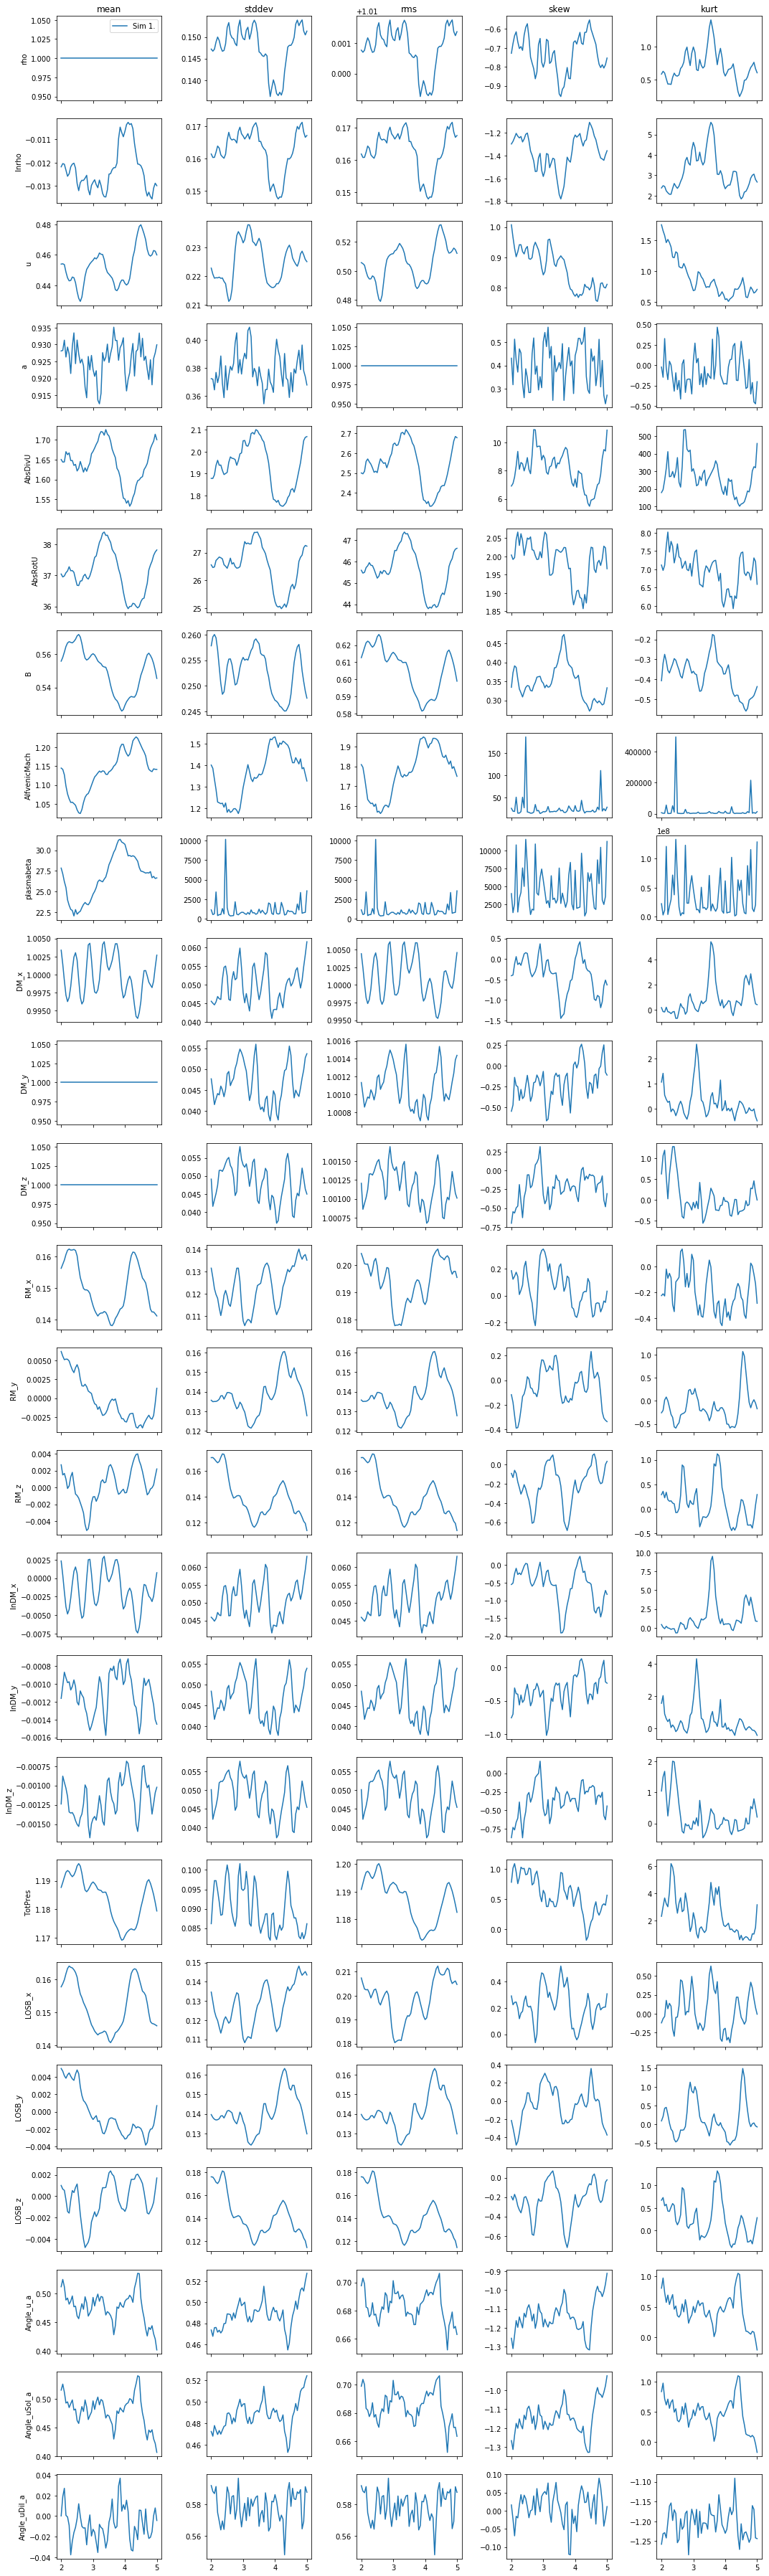

In [45]:
NumRows = len(FieldNames)
NumCols = len(Stats)

fig,p = plt.subplots(NumRows,NumCols,figsize=(3*NumCols,2*NumRows),sharex=True)
for i,field in enumerate(FieldNames):
    for j, stat in enumerate(Stats): 
        globMin = 1e30
        globMax = -1e30
        for Id in Ids:
            AnaRes = Simulations[Id]["AnaRess"][0]    
            tmpY = []          
            tmpX =[]        
            for Dump in sorted(FlowStats[Id][AnaRes].keys()):
                if Dump < 40:
                    #print("skipping first dump")
                    continue
                tmpX.append(float(Dump)/20.)                
                tmpY.append(FlowStats[Id][AnaRes][Dump][field + '/moments/' + stat])

            if np.min(tmpY) < globMin:
                globMin = np.min(tmpY)
            if np.max(tmpY) > globMax:
                globMax = np.max(tmpY)            

            p[i,j].plot(tmpX,tmpY,label=IdLabels[Id])
            
        if i == 0:
            p[i,j].set_title(stat)
        if j == 0:
            p[i,j].set_ylabel(field)
        
    #print("'%s' : [%.5g,%.5g]," % (field,globMin,globMax))    
    
        
    #p[i,0].set_ylabel(field)
    
p[0,0].legend()    
fig.tight_layout()
#fig.subplots_adjust(wspace=0.01,hspace=0.00)    


# Get global min/max (to determine histogram bounds in script)

In [37]:
FieldNames = ['rho',              
              'u',
              'a',]

'rho' : [0.11466,1.9943],
'u' : [0.00013359,2.1512],
'a' : [0.00037264,2.7252],


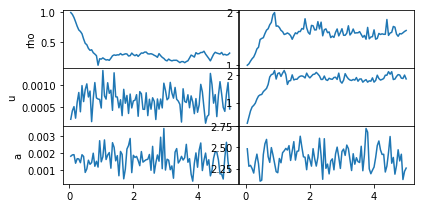

In [39]:

fig,p = plt.subplots(len(FieldNames),2,figsize=(6,len(FieldNames)),sharex=True)
for i,field in enumerate(FieldNames):
    globMin = 1e30
    globMax = -1e30
    for Id in Ids:
        AnaRes = Simulations[Id]["AnaRess"][0]    
        tmpMax = []
        tmpMin = []
        tmpX =[]        
        for Dump in sorted(FlowStats[Id][AnaRes].keys()):
            if Dump == 0:
                #print("skipping first dump")
                continue
            tmpX.append(float(Dump)/20.)
            tmpMax.append(FlowStats[Id][AnaRes][Dump][field + '/moments/max'])
            tmpMin.append(FlowStats[Id][AnaRes][Dump][field + '/moments/min'])

        if np.min(tmpMin) < globMin:
            globMin = np.min(tmpMin)
        if np.max(tmpMax) > globMax:
            globMax = np.max(tmpMax)            
        
        p[i,0].plot(tmpX,tmpMin,label=IdLabels[Id])
        p[i,1].plot(tmpX,tmpMax,label=IdLabels[Id])
        
    print("'%s' : [%.5g,%.5g]," % (field,globMin,globMax))    
    
        
    p[i,0].set_ylabel(field)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.01,hspace=0.00)    